In [72]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.arima.model as smta
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

In [73]:
series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/weekly-closings-of-the-dowjones-.csv").dropna().values[:, 1]

In [74]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [75]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


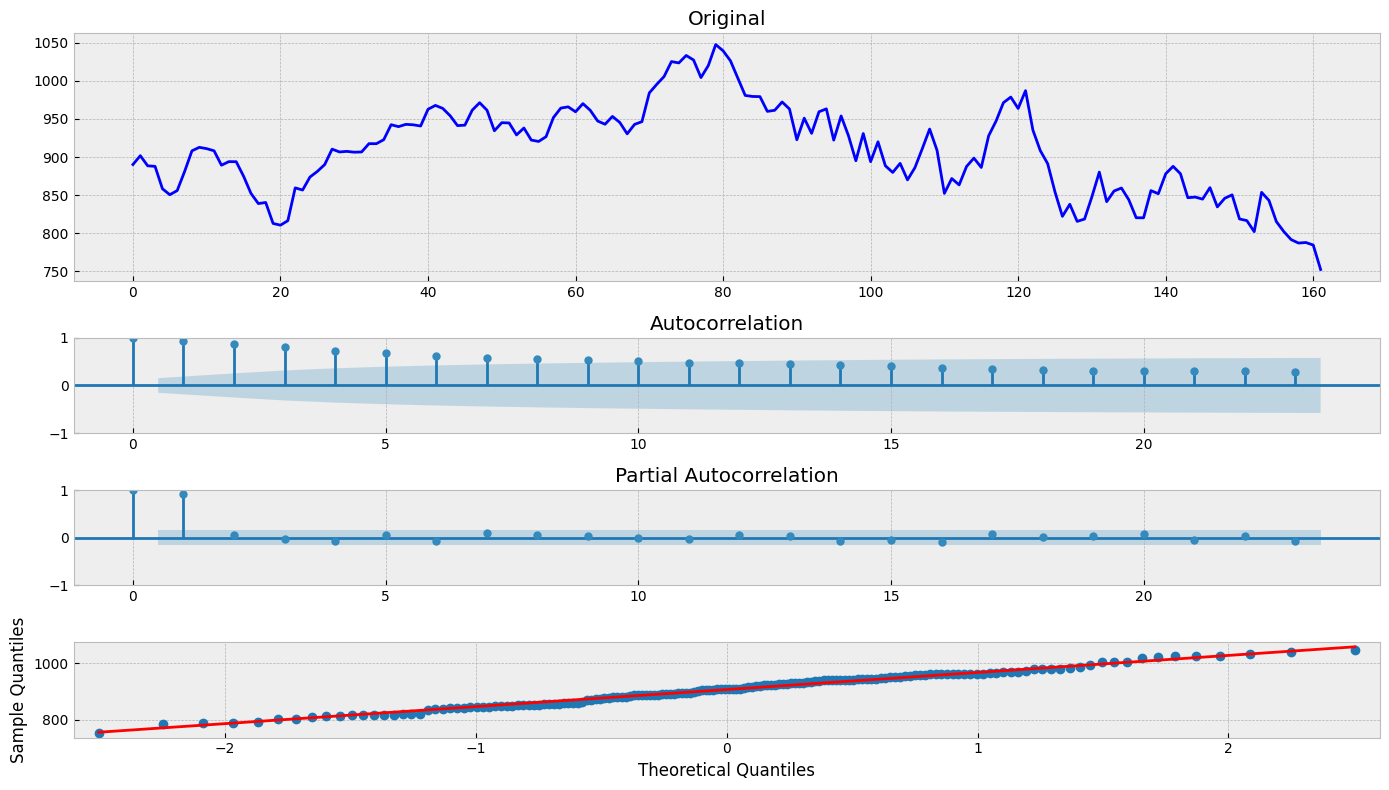

In [76]:
tsplot(series)

In [77]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [78]:
series = series.astype(float)

In [79]:
p_ = 4
o_ = 0
q_ = 4

am = arch_model(series, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -700.787
Distribution:      Standardized Student's t   AIC:                           1411.57
Method:                  Maximum Likelihood   BIC:                           1426.59
                                              No. Observations:                  149
Date:                      Sat, Mar 15 2025   Df Residuals:                      148
Time:                              10:30:53   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

Results of Dickey-Fuller Test:
Test Statistic                  -3.365230
p-value                          0.012203
#Lags Used                      14.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


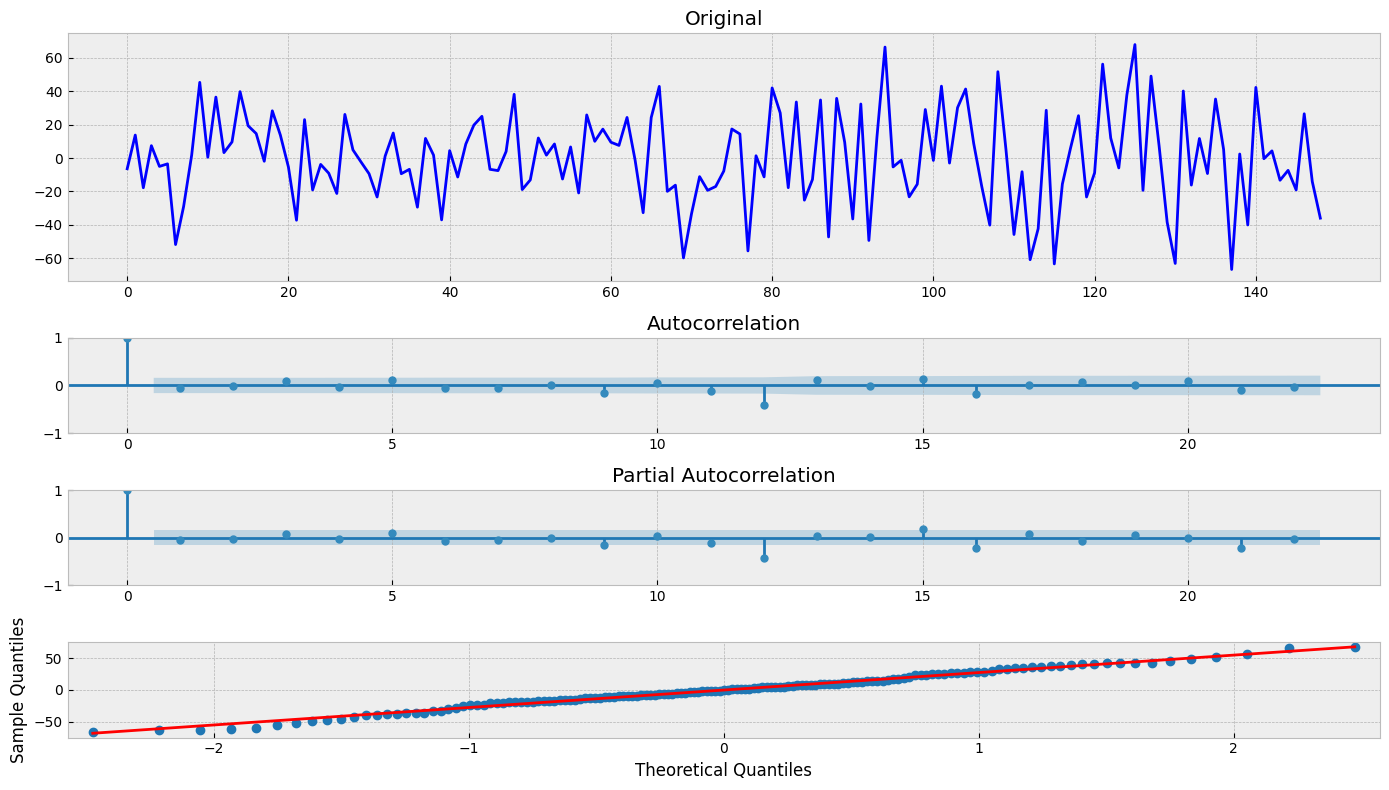

In [80]:
tsplot(res.resid)

In [81]:
from sklearn.linear_model import LinearRegression

In [82]:
# Загрузка данных
series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/monthly-boston-armed-robberies-j.csv")

In [83]:
# Создание дополнительных признаков на основе временного ряда
s = pd.DataFrame(series['Count'])
s.columns = ['curr_value']

window = 10
for i in range(1, window + 1):
    s[f'prev_val_{i}'] = s['curr_value'].shift(i)

s.dropna(inplace=True)
s.head(5)

,curr_value,prev_val_1,prev_val_2,prev_val_3,prev_val_4,prev_val_5,prev_val_6,prev_val_7,prev_val_8,prev_val_9,prev_val_10
10,29,35.0,39.0,35.0,44.0,38.0,43.0,40.0,50.0,39.0,41.0
11,49,29.0,35.0,39.0,35.0,44.0,38.0,43.0,40.0,50.0,39.0
12,50,49.0,29.0,35.0,39.0,35.0,44.0,38.0,43.0,40.0,50.0
13,59,50.0,49.0,29.0,35.0,39.0,35.0,44.0,38.0,43.0,40.0
14,63,59.0,50.0,49.0,29.0,35.0,39.0,35.0,44.0,38.0,43.0


In [84]:
# Подготовка данных для обучения и тестирования модели
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # Индекс начала тестовой выборки
    test_index = int(len(data)*(1-test_size))

    # Добавление лагов исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.Count.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)

    # Разделение данных на обучающую и тестовую выборки
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]

    return X_train, X_test, y_train, y_test

In [85]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

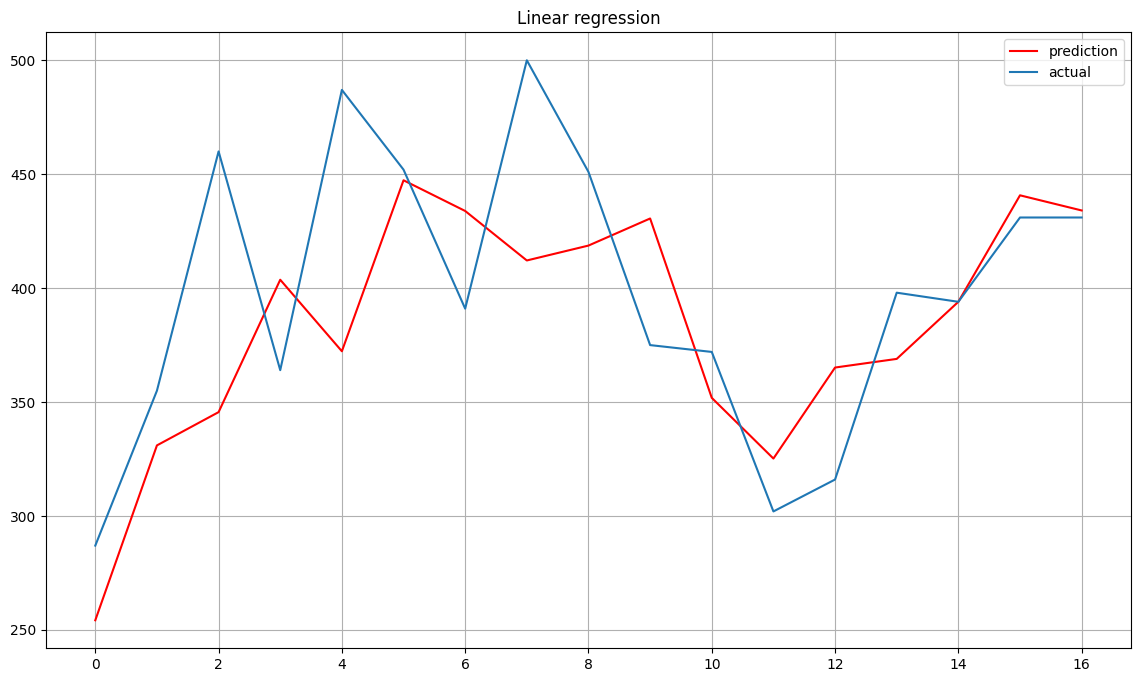

In [86]:
# Обучение модели линейной регрессии
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

# Визуализация прогнозов и фактических значений
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)